# TF-IDF + XGBoost (GPU version)


In [1]:
import xgboost as xgb, sys
print("xgboost:", xgb.__version__, "| python:", sys.version.split()[0])

xgboost: 2.1.1 | python: 3.10.19


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd, numpy as np, random
from sklearn.model_selection import train_test_split

PROJECT_DIR = r"C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2"
DATA_PATH   = rf"{PROJECT_DIR}\jarvis-calling-hiring-contest\Resume\Resume.csv"

TEXT_COL  = "Resume_str"
LABEL_COL = "Category"
SEED = 42
random.seed(SEED); np.random.seed(SEED)

try:
    train_df, val_df, test_df
except NameError:
    df = pd.read_csv(DATA_PATH).dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
    train_df, temp_df = train_test_split(df, test_size=0.20, random_state=SEED, stratify=df[LABEL_COL])
    val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df[LABEL_COL])

all_labels = sorted(train_df[LABEL_COL].unique())
label2id = {c:i for i,c in enumerate(all_labels)}
id2label = {i:c for c,i in label2id.items()}
NUM_CLASSES = len(all_labels)

y_train = train_df[LABEL_COL].map(label2id).values
y_val   = val_df[LABEL_COL].map(label2id).values
y_test  = test_df[LABEL_COL].map(label2id).values

print("train/val/test:", train_df.shape, val_df.shape, test_df.shape, "| NUM_CLASSES:", NUM_CLASSES)


train/val/test: (1987, 4) (248, 4) (249, 4) | NUM_CLASSES: 24


In [4]:
import re, unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text_min(s: str) -> str:
    if not isinstance(s, str): return ""
    s = unicodedata.normalize("NFKC", s).lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Hiperparámetros TF-IDF (ajústalos si quieres)
NGRAMS = (1, 2)
MAX_FEATS = 120_000
MIN_DF = 2
MAX_DF = 0.95

tfidf = TfidfVectorizer(
    preprocessor=clean_text_min,
    analyzer="word",
    ngram_range=NGRAMS,
    max_features=MAX_FEATS,
    min_df=MIN_DF,
    max_df=MAX_DF,
    dtype=np.float32
)

X_tr = tfidf.fit_transform(train_df[TEXT_COL].tolist())
X_va = tfidf.transform(val_df[TEXT_COL].tolist())
X_te = tfidf.transform(test_df[TEXT_COL].tolist())

X_tr.shape, X_va.shape, X_te.shape


((1987, 120000), (248, 120000), (249, 120000))

In [5]:
import numpy as np
from collections import Counter

cnt = Counter(y_train)
classes = np.arange(NUM_CLASSES)
class_weights = np.array([1.0 / cnt.get(c, 1) for c in classes], dtype=np.float32)
sample_weight_tr = class_weights[y_train]  # vector de pesos por muestra
print("Ejemplo pesos por clase (id -> peso):", dict(zip(classes, class_weights.round(3))))


Ejemplo pesos por clase (id -> peso): {0: 0.011, 1: 0.011, 2: 0.02, 3: 0.013, 4: 0.012, 5: 0.034, 6: 0.011, 7: 0.011, 8: 0.056, 9: 0.01, 10: 0.011, 11: 0.011, 12: 0.011, 13: 0.012, 14: 0.013, 15: 0.011, 16: 0.011, 17: 0.011, 18: 0.011, 19: 0.011, 20: 0.01, 21: 0.011, 22: 0.011, 23: 0.012}


In [6]:
import xgboost as xgb
import numpy as np

# Asegura tipos OK
y_tr_i = y_train.astype(np.int32); y_va_i = y_val.astype(np.int32)

dtrain = xgb.DMatrix(X_tr, label=y_tr_i)              # sin sample_weight para aislar
dvalid = xgb.DMatrix(X_va, label=y_va_i)

params = {
    "objective": "multi:softprob",
    "num_class": int(NUM_CLASSES),
    "eval_metric": ["mlogloss","merror"],
    # GPU si tu build >=2.0; si falla, comenta "device" y deja tree_method
    "device": "cuda",
    "tree_method": "gpu_hist",
    # Hiperparams "agresivos" para ver movimiento
    "learning_rate": 0.2,     # sube eta para salir del llano
    "max_depth": 6,
    "min_child_weight": 1.0,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "random_state": 42,
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain,"train"), (dvalid,"valid")],
    early_stopping_rounds=100,
    verbose_eval=50
)
print("best_iteration:", getattr(bst, "best_iteration", None))


[0]	train-mlogloss:1.98621	train-merror:0.15803	valid-mlogloss:2.13548	valid-merror:0.30645
[50]	train-mlogloss:0.01951	train-merror:0.00000	valid-mlogloss:0.83334	valid-merror:0.23387
[100]	train-mlogloss:0.01002	train-merror:0.00000	valid-mlogloss:0.85776	valid-merror:0.22984
[150]	train-mlogloss:0.00809	train-merror:0.00000	valid-mlogloss:0.87067	valid-merror:0.22177
[200]	train-mlogloss:0.00726	train-merror:0.00000	valid-mlogloss:0.88082	valid-merror:0.22984
[249]	train-mlogloss:0.00686	train-merror:0.00000	valid-mlogloss:0.88312	valid-merror:0.22984
best_iteration: 150


In [7]:
def predict_proba_booster(booster, X):
    dX = xgb.DMatrix(X)
    if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
        return booster.predict(dX, iteration_range=(0, int(booster.best_iteration)+1))
    return booster.predict(dX)

y_prob_te = predict_proba_booster(bst, X_te)
y_pred_te = y_prob_te.argmax(1)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
acc = accuracy_score(y_test, y_pred_te)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_test, y_pred_te, average="macro", zero_division=0)
print({"accuracy":acc, "precision_macro":prec_m, "recall_macro":rec_m, "f1_macro":f1_m})
print(classification_report(y_test, y_pred_te, target_names=[id2label[i] for i in range(NUM_CLASSES)], digits=4))


{'accuracy': 0.8032128514056225, 'precision_macro': 0.8142526182967359, 'recall_macro': 0.782807239057239, 'f1_macro': 0.7846779362500778}
                        precision    recall  f1-score   support

            ACCOUNTANT     0.8462    0.9167    0.8800        12
              ADVOCATE     0.9167    0.9167    0.9167        12
           AGRICULTURE     1.0000    0.6667    0.8000         6
               APPAREL     0.8000    0.4444    0.5714         9
                  ARTS     0.5000    0.5455    0.5217        11
            AUTOMOBILE     0.5000    0.6667    0.5714         3
              AVIATION     0.8462    0.9167    0.8800        12
               BANKING     1.0000    0.5833    0.7368        12
                   BPO     1.0000    0.5000    0.6667         2
  BUSINESS-DEVELOPMENT     0.9091    0.8333    0.8696        12
                  CHEF     0.8889    0.6667    0.7619        12
          CONSTRUCTION     0.7500    0.8182    0.7826        11
            CONSULTANT     0

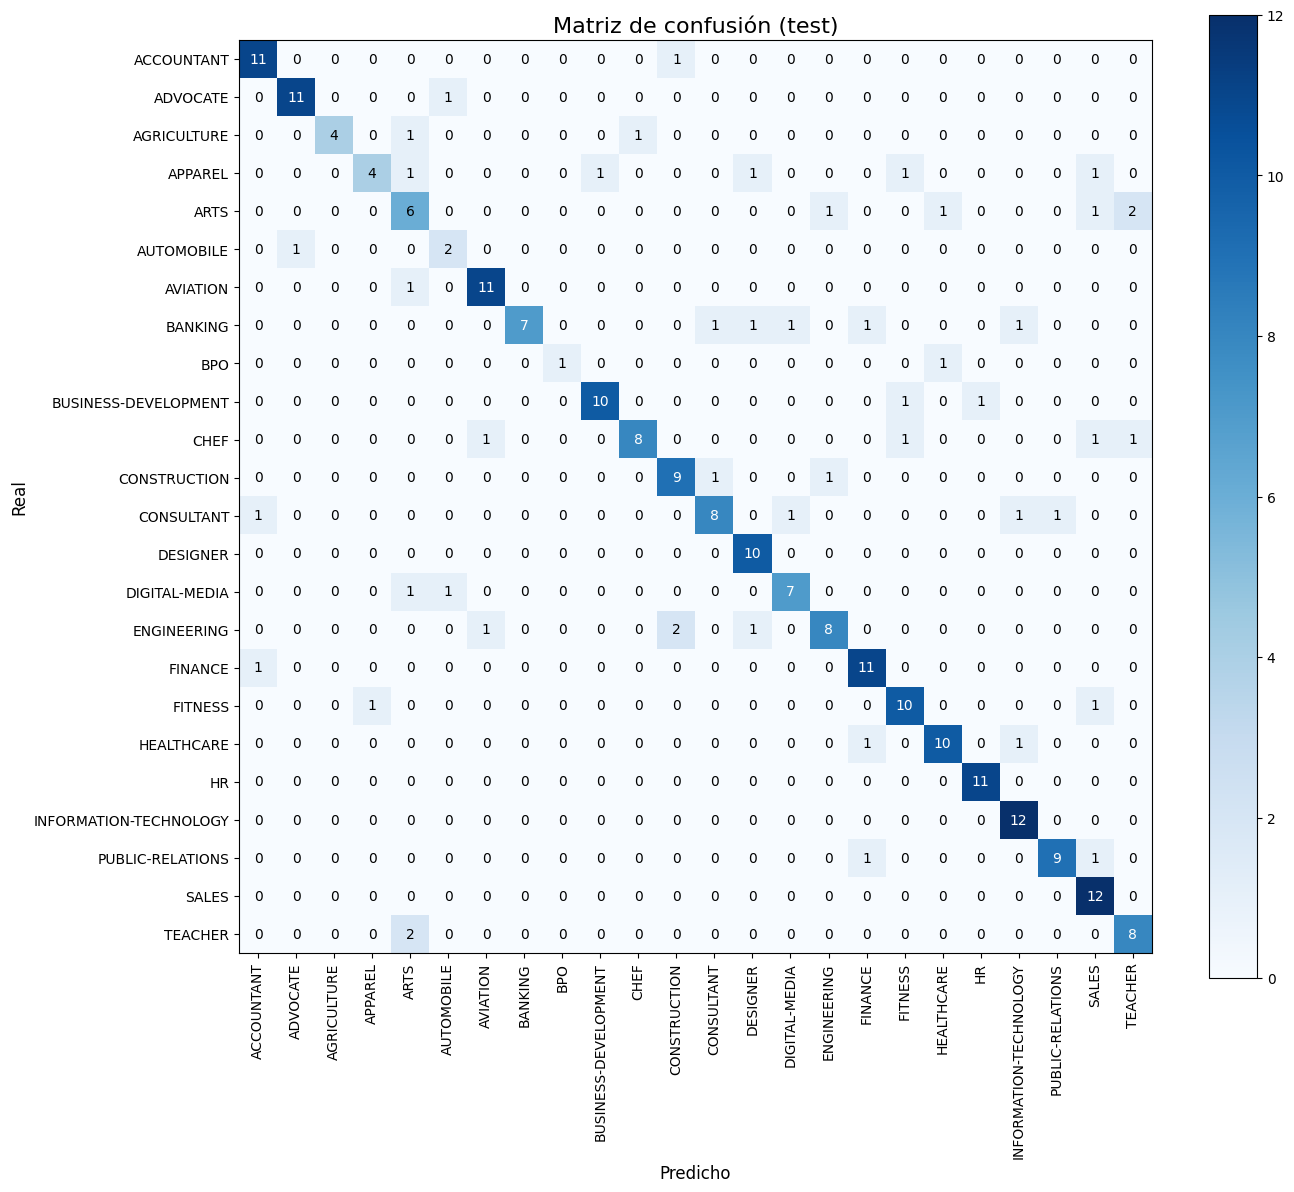

In [8]:
# Matriz de confusión con figura más grande y anotaciones
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred_te)

fig, ax = plt.subplots(figsize=(14, 12))  # ajustar tamaño aquí
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title("Matriz de confusión (test)", fontsize=16)
ticks = np.arange(len(id2label))
labels = [id2label[i] for i in ticks]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel("Predicho", fontsize=12)
ax.set_ylabel("Real", fontsize=12)

# Añadir los números en cada celda
fmt = "d"
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black", fontsize=10)

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import roc_auc_score

try:
    roc_macro_ovr = roc_auc_score(y_test, y_prob_te, multi_class="ovr", average="macro")
    print("ROC-AUC macro (OvR) en test:", round(float(roc_macro_ovr), 4))
except Exception as e:
    print("ROC-AUC no disponible:", e)


ROC-AUC macro (OvR) en test: 0.9866


In [10]:
import numpy as np
import xgboost as xgb

def _xgb_predict_proba(booster_or_clf, X):
    # Soporta xgb.Booster (xgb.train) y XGBClassifier (sklearn API)
    if isinstance(booster_or_clf, xgb.Booster):
        dX = xgb.DMatrix(X)
        if hasattr(booster_or_clf, "best_iteration") and booster_or_clf.best_iteration is not None:
            it = int(booster_or_clf.best_iteration) + 1
            return booster_or_clf.predict(dX, iteration_range=(0, it))
        return booster_or_clf.predict(dX)
    else:
        # XGBClassifier
        return booster_or_clf.predict_proba(X)



In [11]:
def predict_texts_xgb(text_list, tfidf, booster_or_clf, id2label, topk=1):
    """
    text_list: lista de strings crudos
    tfidf:     TfidfVectorizer ya fit-eado (el mismo del training)
    booster_or_clf: xgb.Booster (xgb.train) o XGBClassifier (sklearn)
    id2label:  dict {id:int -> label:str}
    topk:      devuelve top-k si >1
    """
    # Vectoriza con el mismo TF-IDF del entrenamiento (él aplica su preprocessor interno)
    X = tfidf.transform([str(t) for t in text_list])

    # Probabilidades por clase
    prob = _xgb_predict_proba(booster_or_clf, X)  # shape: [N, C]

    # Top-1
    pred_idx = prob.argmax(axis=1)
    labels = [id2label[i] for i in pred_idx]

    if topk == 1:
        return labels, prob

    # Top-k
    topk_idx = np.argsort(-prob, axis=1)[:, :topk]
    topk_labels = [[id2label[i] for i in row] for row in topk_idx]
    topk_conf = np.take_along_axis(prob, topk_idx, axis=1)
    return labels, prob, topk_labels, topk_conf


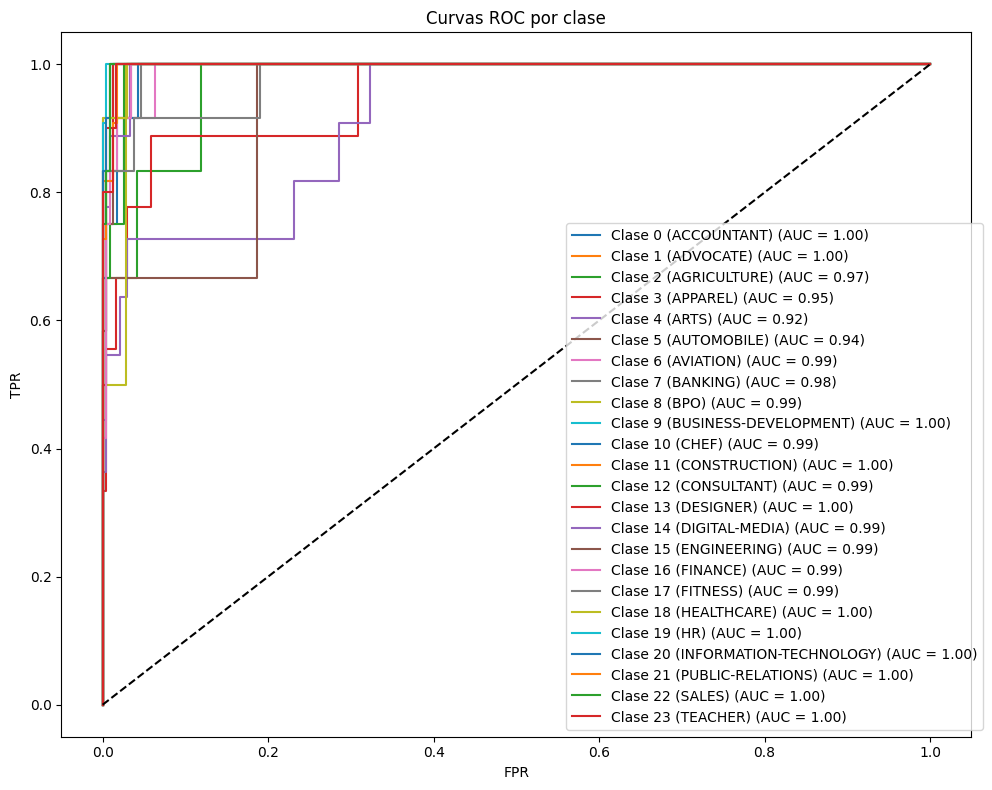

In [15]:
# 8. Curva ROC
# Import only the missing utilities
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# We already have y_prob and y_true from previous computations
probs = y_prob_te

labels_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} ({id2label.get(i,"")}) (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right', bbox_to_anchor=(1.02, 0))
plt.tight_layout()
plt.show()

In [14]:
texts = [
    "Experienced data scientist with NLP background.",
    "5+ years in clinical healthcare operations and patient records.",
    "Designed automotive embedded systems for electric vehicles."
]

# Top-1
labels, prob = predict_texts_xgb(texts, tfidf, bst, id2label, topk=1)
for t, lab, p in zip(texts, labels, prob.max(axis=1)):
    print(f"[TOP1] {lab:>20}  conf={p:.3f}  |  {t[:60]}...")

# Top-3
labels1, prob1, top3_labels, top3_conf = predict_texts_xgb(texts, tfidf, bst, id2label, topk=3)
for i, t in enumerate(texts):
    triples = ", ".join([f"{l} ({c:.2f})" for l, c in zip(top3_labels[i], top3_conf[i])])
    print(f"[TOP3] {triples}  |  {t[:60]}...")

[TOP1] BUSINESS-DEVELOPMENT  conf=0.900  |  Experienced data scientist with NLP background....
[TOP1]           HEALTHCARE  conf=0.958  |  5+ years in clinical healthcare operations and patient recor...
[TOP1] BUSINESS-DEVELOPMENT  conf=0.900  |  Designed automotive embedded systems for electric vehicles....
[TOP3] BUSINESS-DEVELOPMENT (0.90), AVIATION (0.01), AUTOMOBILE (0.01)  |  Experienced data scientist with NLP background....
[TOP3] HEALTHCARE (0.96), BUSINESS-DEVELOPMENT (0.04), AVIATION (0.00)  |  5+ years in clinical healthcare operations and patient recor...
[TOP3] BUSINESS-DEVELOPMENT (0.90), AVIATION (0.01), AUTOMOBILE (0.01)  |  Designed automotive embedded systems for electric vehicles....


,precision,recall,f1-score,support
ARTS,0.500000,0.545455,0.521739,11.0
APPAREL,0.800000,0.444444,0.571429,9.0
AUTOMOBILE,0.500000,0.666667,0.571429,3.0
BPO,1.000000,0.500000,0.666667,2.0
CONSULTANT,0.800000,0.666667,0.727273,12.0
ENGINEERING,0.800000,0.666667,0.727273,12.0
BANKING,1.000000,0.583333,0.736842,12.0
TEACHER,0.727273,0.800000,0.761905,10.0
CHEF,0.888889,0.666667,0.761905,12.0
DIGITAL-MEDIA,0.777778,0.777778,0.777778,9.0


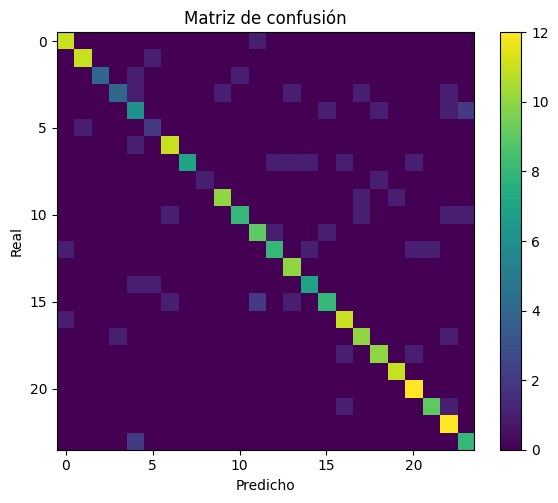

[(2, 'TEACHER', 'ARTS'),
 (2, 'ENGINEERING', 'CONSTRUCTION'),
 (2, 'ARTS', 'TEACHER'),
 (1, 'PUBLIC-RELATIONS', 'SALES'),
 (1, 'PUBLIC-RELATIONS', 'FINANCE'),
 (1, 'HEALTHCARE', 'INFORMATION-TECHNOLOGY'),
 (1, 'HEALTHCARE', 'FINANCE'),
 (1, 'FITNESS', 'SALES'),
 (1, 'FITNESS', 'APPAREL'),
 (1, 'FINANCE', 'ACCOUNTANT')]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Using y_test and y_pred_te from previous evaluation
rep = classification_report(y_test, y_pred_te, target_names=[id2label[i] for i in range(NUM_CLASSES)],
                            output_dict=True, digits=4)
df_rep = pd.DataFrame(rep).transpose().sort_values('f1-score', ascending=True)
display(df_rep.head(10))  # clases más débiles

cm = confusion_matrix(y_test, y_pred_te)
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation="nearest"); plt.colorbar()
plt.title("Matriz de confusión"); plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout(); plt.show()

# Top confusiones
pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i!=j and cm[i,j]>0:
            pairs.append((cm[i,j], id2label[i], id2label[j]))
pairs = sorted(pairs, reverse=True)[:10]
pairs